<a href="https://colab.research.google.com/github/alankritmishra/DL-Notebooks/blob/master/Activity_Recognition_Using_Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import numpy as np
import pylab as pl
import pandas as pd

import scipy.stats
import random
import sys,itertools
from time import process_time

import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
style.use('ggplot')

import io
import requests
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.manifold import TSNE


from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from numpy.linalg import svd

import tensorflow as tf
import tensorflow.keras as tfkeras
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling1D, Conv1D, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD

TRAIN_URL = "https://drive.google.com/uc?export=download&id=16q7ZkNOSHgJ6TtEg4ngQ_MtBoC824ByN"
TEST_URL = "https://drive.google.com/uc?export=download&id=1Nd9GZT6cvx0KHEhg0bDt6VnF6picYlED"

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Dataset Loading and pre-processing

In [ ]:
train_data_raw = requests.get(TRAIN_URL).content
train_data = shuffle(pd.read_csv(io.StringIO(train_data_raw.decode("utf-8"))))
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
1747,0.139646,-0.021323,-0.082665,-0.229222,0.293903,-0.028488,-0.289455,0.261607,0.010845,-0.213079,0.090780,-0.154569,0.159660,-0.010737,0.468750,0.033624,-0.697866,-0.677568,-0.575640,-0.346261,-0.039972,0.012188,0.290380,0.313476,-0.006868,-0.286320,0.278901,-0.253428,0.201597,-0.367817,0.331675,-0.047206,0.015017,0.151564,-0.214822,0.092357,0.155596,-0.131086,-0.171595,-0.030506,...,0.394514,-0.904762,0.338758,-0.604825,-0.892423,0.041152,-0.033397,0.086234,-0.226534,-0.028525,0.041152,-0.382394,-0.042345,0.650910,-0.897436,0.012206,-0.439486,-0.774649,-0.439242,-0.548389,-0.433894,-0.695910,-0.889393,-0.439242,-0.857403,-0.426345,0.557405,-0.746032,0.202602,-0.625431,-0.912435,0.724824,0.447974,-0.466031,-0.131627,-0.710041,0.298114,0.030142,8,WALKING_UPSTAIRS
6360,0.273828,-0.017161,-0.111075,-0.977354,-0.970372,-0.984023,-0.979419,-0.969661,-0.983267,-0.921679,-0.559342,-0.813863,0.828228,0.680804,0.839151,-0.977955,-0.999645,-0.999720,-0.999653,-0.982573,-0.973799,-0.981334,-0.305711,-0.455511,-0.564843,-0.097597,0.031037,-0.008891,-0.057016,0.150997,-0.113311,0.062904,0.092415,0.323562,-0.098103,0.116432,-0.438149,0.678910,-0.639002,-0.477887,...,-1.000000,-0.714286,0.267252,-0.519126,-0.840757,-0.977108,-0.972160,-0.967794,-0.980689,-0.994355,-0.977108,-0.999490,-0.972361,-0.561208,-0.948718,-0.378219,-0.539282,-0.865388,-0.990412,-0.992761,-0.991727,-0.994865,-0.998083,-0.990412,-0.999935,-0.991237,-0.923452,-0.904762,0.182434,-0.680576,-0.897382,0.523424,-0.070033,0.255181,0.275198,0.445521,-0.320692,-0.677364,28,LAYING
2167,0.270881,0.005586,-0.119672,-0.480875,0.010226,-0.598251,-0.522119,0.026077,-0.591285,-0.274796,-0.046404,-0.521531,0.394950,0.094784,0.676999,-0.330876,-0.863942,-0.801687,-0.923976,-0.618784,-0.215299,-0.588347,0.339704,0.362958,-0.059286,-0.516788,0.470728,-0.267696,0.171085,0.004516,-0.070842,0.418640,-0.225563,-0.059164,0.145453,-0.026801,-0.309167,0.059373,-0.005367,0.181167,...,0.236723,-0.904762,0.244912,-0.038528,-0.385800,-0.619329,-0.629011,-0.577929,-0.705300,-0.902064,-0.619329,-0.911794,-0.635685,0

In [ ]:
train_data.describe()
# train_data.plot(kind='box', subplots=True, layout=(33,17), sharex=False, sharey=False)
# plt.show()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,-0.306043,-0.557121,0.523551,0.387386,0.594374,-0.547569,-0.820041,-0.901874,-0.845784,-0.684345,-0.643770,-0.631069,-0.102993,-0.137937,-0.163946,-0.116599,0.102762,-0.037786,0.130477,-0.026229,0.026322,0.159966,-0.019575,0.009420,0.033291,0.036587,-0.078640,-0.125131,-0.193802,0.105005,...,-0.678618,-0.347657,-0.877995,0.178195,-0.312968,-0.615441,-0.693210,-0.692876,-0.674830,-0.726645,-0.885103,-0.693210,-0.874292,-0.719795,-0.087878,-0.889442,-0.046516,-0.253649,-0.565425,-0.779376,-0.792391,-0.772836,-0.811409,-0.871927,-0.779376,-0.935785,-0.771497,-0.284627,-0.898859,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,0.282243,0.293867,0.363594,0.343611,0.297818,0.471808,0.259607,0.126333,0.221983,0.371608,0.371581,0.386569,0.468959,0.437268,0.371363,0.306507,0.246593,0.243635,0.230067,0.257383,0.215001,0.208837,0.221432,0.

In [ ]:
test_data_raw = requests.get(TEST_URL).content
test_data = shuffle(pd.read_csv(io.StringIO(test_data_raw.decode("utf-8"))))
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
1392,0.278026,-0.014839,-0.118062,-0.939947,-0.636643,-0.844700,-0.944711,-0.611555,-0.823022,-0.878543,-0.373230,-0.749281,0.744003,0.503124,0.774945,-0.814818,-0.997950,-0.973560,-0.987145,-0.955420,-0.649814,-0.795594,0.048396,0.032408,-0.090164,-0.091015,0.093126,-0.155094,0.143977,-0.337634,0.164140,0.233158,-0.309214,-0.105250,-0.001919,0.057940,-0.111058,0.785918,0.503151,0.756305,...,-0.600607,-1.000000,-0.036931,-0.521573,-0.835151,-0.713743,-0.382041,-0.547577,-0.452065,-0.845985,-0.713743,-0.835915,-0.883652,-0.220026,-0.948718,-0.630564,0.165965,-0.301031,-0.943857,-0.943060,-0.930210,-0.956737,-0.993030,-0.943857,-0.998143,-0.912073,-0.363573,-0.968254,-0.350333,-0.456256,-0.795755,0.044576,0.096963,-0.928728,-0.944080,-0.708618,0.299158,0.029100,12,STANDING
10,0.278596,-0.015232,-0.098908,-0.998785,-0.981943,-0.991379,-0.998828,-0.980015,-0.991409,-0.943761,-0.567017,-0.814326,0.852843,0.689106,0.849271,-0.991989,-0.999994,-0.999862,-0.999720,-0.998556,-0.979756,-0.989734,-0.714892,-0.503601,-0.385388,0.354777,-0.105280,0.146428,0.096250,0.252232,-0.152166,0.187102,-0.160753,0.469010,-0.275800,0.125308,-0.031153,-0.082045,0.038599,0.280582,...,-1.000000,-0.968254,0.389003,-0.492430,-0.799204,-0.994166,-0.995525,-0.994868,-0.995533,-0.995167,-0.994166,-0.999965,-0.992132,-0.956057,-0.846154,0.256752,-0.645616,-0.840499,-0.996505,-0.997490,-0.996703,-0.998717,-0.994937,-0.996505,-0.999986,-0.995606,-1.000000,-0.682540,0.691965,-0.929881,-0.986342,-0.047689,0.077152,-0.786023,-0.285308,-0.686013,0.298478,-0.066625,2,STANDING
2442,0.280136,-0.020712,-0.087625,-0.993448,-0.966256,-0.970239,-0.994387,-0.965510,-0.969255,-0.935128,-0.553405,-0.795577,0.844779,0.678262,0.838312,-0.977910,-0.999950,-0.999631,-0.998559,-0.995396,-0.969037,-0.971321,-0.515383,-0.542091,-0.158771,0.096170,-0.009019,-0.096020,0.580428,-0.018266,-0.048688,0.231452,-0.053958,-0.106990,0.087802,-0.029029,-0.119274,0.206996,0.008400,-0.333302,...,-1.000000,-0.873016,0.329348,-0.482431,-0.824734,-0.965406,-0.954501,-0.960890,-0.950691,-0.975920,-0.965406,-0.998789,-

In [ ]:
# Splitting train features and labels
X_train = train_data.iloc[:,:-2]
y_train_string = train_data.iloc[:,-1]

X_test = test_data.iloc[:,:-2]
y_test_string = test_data.iloc[:,-1]


print('Shape of Train data : ', train_data.shape)
print('Shape of X_Train : ', X_train.shape)
print('Shape of Train class : ', y_train_string.shape)
print('Shape of Test data : ', test_data.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of Test class : ', y_test_string.shape)

Shape of Train data :  (7352, 563)
Shape of X_Train :  (7352, 561)
Shape of Train class :  (7352,)
Shape of Test data :  (2947, 563)
Shape of X_test :  (2947, 561)
Shape of Test class :  (2947,)


In [ ]:
# Processing the raw data with MinMaxScaler scalar
mmsc = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = mmsc.fit_transform(X_train)
X_test_scaled = mmsc.transform(X_test)

In [ ]:
labels = np.unique(y_train_string)
# labels

In [ ]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train_string)
y_train_FL = pd.get_dummies(y_train).values
# y_train

In [ ]:
y_test = encoder.fit_transform(y_test_string)
y_test_FL = pd.get_dummies(y_test).values
# y_test

In [ ]:
label_counts = y_train_string.value_counts()
label_counts

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [ ]:
n = y_train_string.unique().shape[0]
colormap = get_cmap('tab10')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]
# colors

## Data visualisation with PCA

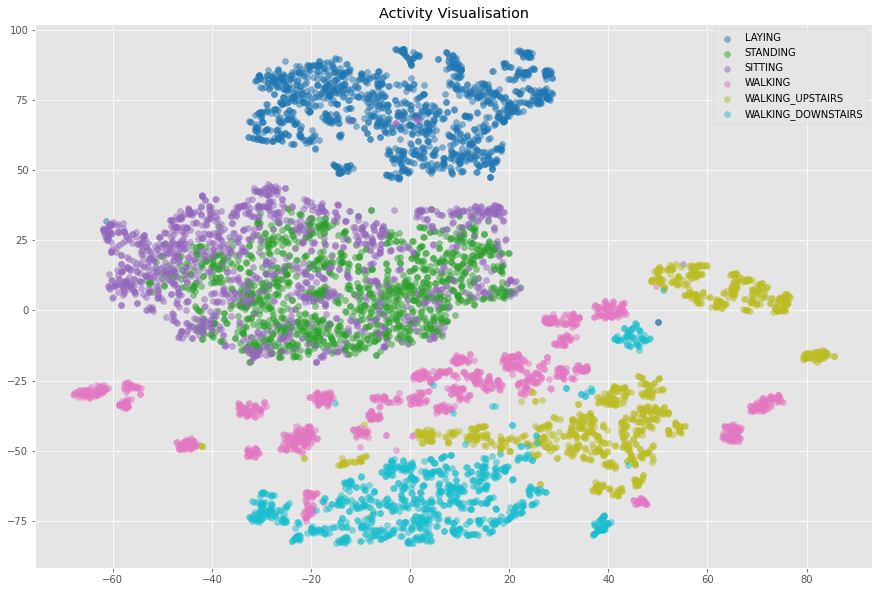

In [ ]:
pca = decomposition.PCA(n_components=0.9, random_state=3)
pca_fit = pca.fit(X_train)
X_train_pca = pca_fit.transform(X_train)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(X_train_pca)

# Create subplots
fig, axarr = plt.subplots(1, 1, figsize=(15,10))

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (y_train_string == group).values
    axarr.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr.set_title('Activity Visualisation')
axarr.legend()

plt.show()

The PCA plot shows that the features a almost separable. So, we can use linearly separable functions.

Now we will find the variance spread of data in the range of principal components

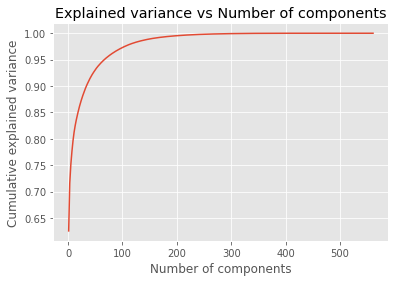

In [ ]:
pca_var = decomposition.PCA(n_components= 561)
X_pca = pca_var.fit_transform(X_train)
var_explained = pca_var.explained_variance_ratio_

cumulative_variance = np.cumsum(var_explained)
x = np.array(range(1,562))
plt.plot(x, cumulative_variance)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")
plt.show()

In [ ]:
# Finding the resultant dimension of PCs
principal_components = 0
for item in cumulative_variance:
    if item <= 0.99:
        principal_components += 1
print("Resultant PCA at variance of 99% is: {}".format(principal_components + 1))

Resultant PCA at variance of 99% is: 155


We can infer that we can get most of the variance of data at 99% of variation spread, so we can reduce the dimension the dataset with first 155 Principal components in feature space.

In [ ]:
pca_var = decomposition.PCA(n_components=155, random_state=3)

pca_training = pca_var.fit(X_train)

pca_training.explained_variance_
pca_training.n_components_
X_train_pca = pca_training.transform(X_train)
X_test_pca = pca_training.transform(X_test)

In [ ]:
X_train_pca.shape

(7352, 155)

In [ ]:
y_test_string

1392              STANDING
10                STANDING
2442               SITTING
2548      WALKING_UPSTAIRS
2401              STANDING
               ...        
2271               SITTING
529                 LAYING
1098               SITTING
121     WALKING_DOWNSTAIRS
1264                LAYING
Name: Activity, Length: 2947, dtype: object

## Feature Selection

### SFS using Desicion tree wrapper

In [ ]:
sfs = SFS(DecisionTreeClassifier(random_state=0),
         k_features = (1, 20),
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1
         ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 554 out of 561 | elapsed:   12.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 561 out of 561 | elapsed:   12.5s finished

[2021-04-17 00:20:03] Features: 1/20 -- score: 0.6867519042437432[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   15.8s finished

[2021-04-17 00:20:19] Features: 2/20 -- score: 0.8526931447225246[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 559 out of 559 | 

In [ ]:
sfs.k_score_

0.965043525571273

In [ ]:
sfs.k_feature_names_

('tBodyAcc-mad()-Y',
 'tBodyAcc-max()-X',
 'tBodyAcc-min()-Z',
 'tGravityAcc-max()-Y',
 'tGravityAcc-max()-Z',
 'tGravityAcc-min()-X',
 'tGravityAcc-min()-Y',
 'tGravityAcc-min()-Z',
 'tGravityAcc-energy()-X',
 'tBodyAccJerk-min()-Y',
 'tBodyGyroJerk-energy()-Y',
 'tBodyAccMag-max()',
 'tBodyGyroJerkMag-energy()',
 'fBodyAcc-bandsEnergy()-1,8',
 'fBodyGyro-bandsEnergy()-1,16.1',
 'angle(Y,gravityMean)')

In [ ]:
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

In [ ]:
X_train_sfs.shape

(7352, 16)

### SFFS using Gaussian NB wrapper

In [ ]:
sffs = SFS(GaussianNB(),
         k_features = (1, 50),
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1
         ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 561 out of 561 | elapsed:    2.5s finished

[2021-04-17 00:32:34] Features: 1/50 -- score: 0.5039445048966268[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    3.3s finished

[2021-04-17 00:32:37] Features: 2/50 -- score: 0.7844124047878128[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 559 out of 559 | elapsed:    3.5s finished

[2021-04-17 00:32:41] Features: 3/50 -- score: 0.8416757344940152[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 558 out o

In [ ]:
sffs.k_score_

0.9436887921653971

In [ ]:
sffs.k_feature_names_

('tBodyAcc-max()-X',
 'tBodyAcc-entropy()-X',
 'tBodyAcc-entropy()-Z',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-correlation()-X,Z',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-min()-Y',
 'tGravityAcc-arCoeff()-Y,1',
 'tGravityAcc-correlation()-Y,Z',
 'tBodyAccJerk-entropy()-X',
 'tBodyAccJerk-arCoeff()-X,1',
 'tBodyAccJerk-arCoeff()-X,2',
 'tBodyAccJerk-arCoeff()-X,4',
 'tBodyAccJerk-arCoeff()-Y,4',
 'tBodyAccJerk-arCoeff()-Z,2',
 'tBodyAccJerk-arCoeff()-Z,3',
 'tBodyAccJerk-arCoeff()-Z,4',
 'tBodyAccJerk-correlation()-X,Z',
 'tBodyAccJerk-correlation()-Y,Z',
 'tBodyGyro-entropy()-X',
 'tBodyGyro-arCoeff()-Y,1',
 'tBodyGyro-arCoeff()-Y,4',
 'tBodyGyro-arCoeff()-Z,3',
 'tBodyGyro-correlation()-X,Z',
 'tBodyGyroJerk-entropy()-X',
 'tBodyGyroJerk-arCoeff()-X,4',
 'tBodyGyroJerk-arCoeff()-Y,1',
 'tBodyGyroJerk-arCoeff()-Z,2',
 'tBodyGyroJerk-arCoeff()-Z,3',
 'tBodyGyroJerk-arCoeff()-Z,4',
 'tBodyAccMag-arCoeff()2',
 'tBodyAccMag-arCoeff()4',
 '

In [ ]:
X_train_sffs = sffs.transform(X_train)
X_test_sffs = sffs.transform(X_test)

In [ ]:
X_train_sffs.shape

(7352, 50)

# Classifier Model

In [ ]:
def plot_confusion_matrix(cm,lables):
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=lables, yticklabels=lables,
    ylabel='True label',
    xlabel='Predicted label')
    plt.xticks(rotation = 90)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [ ]:
clf_models = [
    KNeighborsClassifier(5),
    svm.SVC(kernel='rbf', C=1000, gamma=0.0001),
    DecisionTreeClassifier(max_depth=7),
    RandomForestClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter= 1000),
    LogisticRegression(max_iter= 2000)
]

In [ ]:
def model_score(X_tr, X_te, y_tr, y_te):
    for clf in clf_models:
        start_tm = process_time()
        clf.fit(X_tr,y_tr)
        y_pred = clf.predict(X_te)
        f = metrics.f1_score(y_true=y_te,y_pred=y_pred,average="macro")
        print("Training accuracy for ", clf.__class__.__name__,": ", cross_val_score(clf, X_tr, y_tr, cv=5).mean())
        stop_tm = process_time()
        elapsed_tm = stop_tm - start_tm
        print(f"F1_score: {round(f,3)} \t Time taken: {round(elapsed_tm,3)} secs \t Classifier: {clf.__class__.__name__}")
        cm_raw = metrics.confusion_matrix(y_te, y_pred)
        print("Classification Report for ", clf.__class__.__name__,":\n",metrics.classification_report(y_te, y_pred))
        plt.figure(figsize=(4,4))
        print("Confusion matrix plot showing for ", {clf.__class__.__name__},"\n")
        plot_confusion_matrix(cm_raw, labels)
        plt.show() 
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n")

Training accuracy for  KNeighborsClassifier :  0.966131050652756
F1_score: 0.897 	 Time taken: 45.784 secs 	 Classifier: KNeighborsClassifier
Classification Report for  KNeighborsClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
           SITTING       0.91      0.79      0.85       491
          STANDING       0.83      0.93      0.88       532
           WALKING       0.85      0.98      0.91       496
WALKING_DOWNSTAIRS       0.94      0.79      0.86       420
  WALKING_UPSTAIRS       0.90      0.89      0.89       471

          accuracy                           0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947

Confusion matrix plot showing for  {'KNeighborsClassifier'} 



<Figure size 288x288 with 0 Axes>

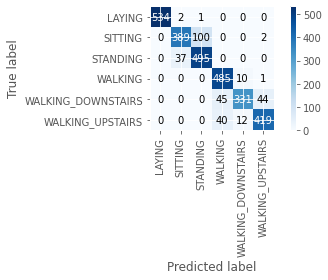

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  SVC :  0.9842219416658573
F1_score: 0.962 	 Time taken: 20.992 secs 	 Classifier: SVC
Classification Report for  SVC :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.89      0.93       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Confusion matrix plot showing for  {'SVC'} 



<Figure size 288x288 with 0 Axes>

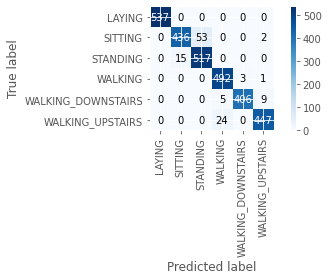

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  DecisionTreeClassifier :  0.9336246803276035
F1_score: 0.863 	 Time taken: 13.181 secs 	 Classifier: DecisionTreeClassifier
Classification Report for  DecisionTreeClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.81      0.79      0.80       491
          STANDING       0.81      0.83      0.82       532
           WALKING       0.84      0.95      0.89       496
WALKING_DOWNSTAIRS       0.90      0.81      0.85       420
  WALKING_UPSTAIRS       0.84      0.79      0.82       471

          accuracy                           0.87      2947
         macro avg       0.87      0.86      0.86      2947
      weighted avg       0.87      0.87      0.87      2947

Confusion matrix plot showing for  {'DecisionTreeClassifier'} 



<Figure size 288x288 with 0 Axes>

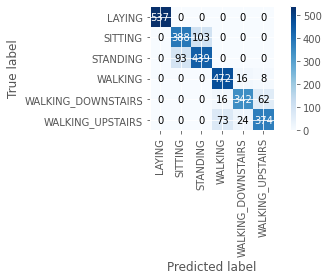

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  RandomForestClassifier :  0.9812292993336016
F1_score: 0.922 	 Time taken: 54.358 secs 	 Classifier: RandomForestClassifier
Classification Report for  RandomForestClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.90      0.90       491
          STANDING       0.91      0.92      0.91       532
           WALKING       0.89      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.84      0.90       420
  WALKING_UPSTAIRS       0.89      0.90      0.89       471

          accuracy                           0.92      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.92      0.92      2947

Confusion matrix plot showing for  {'RandomForestClassifier'} 



<Figure size 288x288 with 0 Axes>

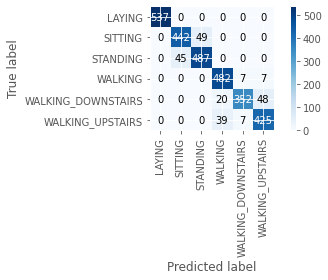

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  GaussianNB :  0.7072743332547159
F1_score: 0.767 	 Time taken: 0.582 secs 	 Classifier: GaussianNB
Classification Report for  GaussianNB :
                     precision    recall  f1-score   support

            LAYING       0.96      0.60      0.74       537
           SITTING       0.58      0.75      0.65       491
          STANDING       0.80      0.86      0.83       532
           WALKING       0.82      0.84      0.83       496
WALKING_DOWNSTAIRS       0.83      0.61      0.70       420
  WALKING_UPSTAIRS       0.76      0.96      0.84       471

          accuracy                           0.77      2947
         macro avg       0.79      0.77      0.77      2947
      weighted avg       0.79      0.77      0.77      2947

Confusion matrix plot showing for  {'GaussianNB'} 



<Figure size 288x288 with 0 Axes>

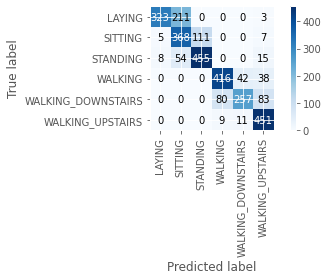

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  MLPClassifier :  0.9846294574933984
F1_score: 0.933 	 Time taken: 422.361 secs 	 Classifier: MLPClassifier
Classification Report for  MLPClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      0.97      0.98       537
           SITTING       0.98      0.76      0.86       491
          STANDING       0.80      0.98      0.88       532
           WALKING       0.93      0.99      0.96       496
WALKING_DOWNSTAIRS       0.99      0.96      0.97       420
  WALKING_UPSTAIRS       0.96      0.92      0.94       471

          accuracy                           0.93      2947
         macro avg       0.94      0.93      0.93      2947
      weighted avg       0.94      0.93      0.93      2947

Confusion matrix plot showing for  {'MLPClassifier'} 



<Figure size 288x288 with 0 Axes>

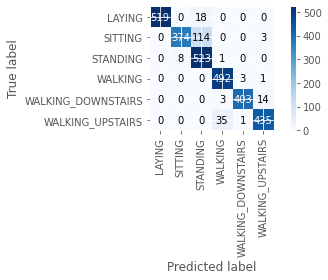

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  LogisticRegression :  0.9854463389706666
F1_score: 0.961 	 Time taken: 443.121 secs 	 Classifier: LogisticRegression
Classification Report for  LogisticRegression :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.88      0.93       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.94      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Confusion matrix plot showing for  {'LogisticRegression'} 



<Figure size 288x288 with 0 Axes>

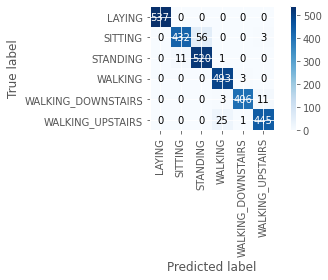

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [ ]:
# evaluating with Raw data
model_score(X_train, X_test, y_train_string, y_test_string)

Training accuracy for  KNeighborsClassifier :  0.9734761396060803
F1_score: 0.82 	 Time taken: 0.715 secs 	 Classifier: KNeighborsClassifier
Classification Report for  KNeighborsClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.78      0.74      0.76       491
          STANDING       0.77      0.81      0.79       532
           WALKING       0.75      0.89      0.81       496
WALKING_DOWNSTAIRS       0.86      0.71      0.78       420
  WALKING_UPSTAIRS       0.79      0.77      0.78       471

          accuracy                           0.82      2947
         macro avg       0.83      0.82      0.82      2947
      weighted avg       0.83      0.82      0.82      2947

Confusion matrix plot showing for  {'KNeighborsClassifier'} 



<Figure size 288x288 with 0 Axes>

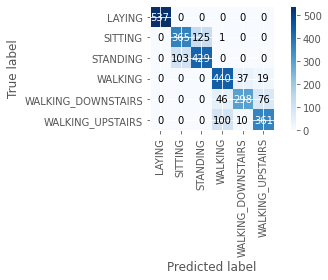

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  SVC :  0.8998906755088167
F1_score: 0.853 	 Time taken: 3.104 secs 	 Classifier: SVC
Classification Report for  SVC :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.86      0.76      0.80       491
          STANDING       0.80      0.88      0.84       532
           WALKING       0.78      0.92      0.85       496
WALKING_DOWNSTAIRS       0.89      0.74      0.80       420
  WALKING_UPSTAIRS       0.84      0.81      0.83       471

          accuracy                           0.86      2947
         macro avg       0.86      0.85      0.85      2947
      weighted avg       0.86      0.86      0.86      2947

Confusion matrix plot showing for  {'SVC'} 



<Figure size 288x288 with 0 Axes>

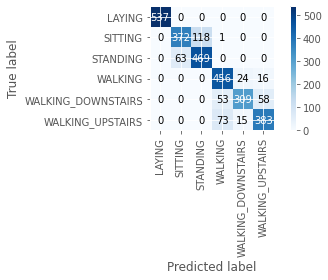

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  DecisionTreeClassifier :  0.9160754172505168
F1_score: 0.786 	 Time taken: 0.465 secs 	 Classifier: DecisionTreeClassifier
Classification Report for  DecisionTreeClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.72      0.82      0.77       491
          STANDING       0.81      0.70      0.75       532
           WALKING       0.75      0.78      0.76       496
WALKING_DOWNSTAIRS       0.82      0.66      0.73       420
  WALKING_UPSTAIRS       0.66      0.75      0.70       471

          accuracy                           0.79      2947
         macro avg       0.79      0.78      0.79      2947
      weighted avg       0.80      0.79      0.79      2947

Confusion matrix plot showing for  {'DecisionTreeClassifier'} 



<Figure size 288x288 with 0 Axes>

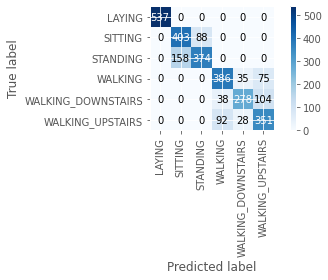

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  RandomForestClassifier :  0.9831340612383634
F1_score: 0.822 	 Time taken: 9.011 secs 	 Classifier: RandomForestClassifier
Classification Report for  RandomForestClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.79      0.79      0.79       491
          STANDING       0.80      0.80      0.80       532
           WALKING       0.78      0.80      0.79       496
WALKING_DOWNSTAIRS       0.90      0.70      0.79       420
  WALKING_UPSTAIRS       0.70      0.82      0.76       471

          accuracy                           0.82      2947
         macro avg       0.83      0.82      0.82      2947
      weighted avg       0.83      0.82      0.83      2947

Confusion matrix plot showing for  {'RandomForestClassifier'} 



<Figure size 288x288 with 0 Axes>

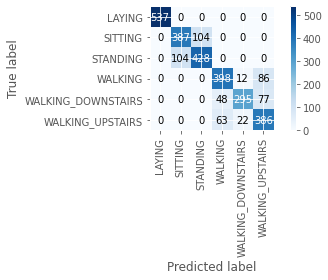

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  GaussianNB :  0.8460264432081466
F1_score: 0.794 	 Time taken: 0.115 secs 	 Classifier: GaussianNB
Classification Report for  GaussianNB :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.65      0.76       491
          STANDING       0.75      0.92      0.83       532
           WALKING       0.63      0.83      0.72       496
WALKING_DOWNSTAIRS       0.84      0.72      0.78       420
  WALKING_UPSTAIRS       0.74      0.63      0.68       471

          accuracy                           0.80      2947
         macro avg       0.81      0.79      0.79      2947
      weighted avg       0.82      0.80      0.80      2947

Confusion matrix plot showing for  {'GaussianNB'} 



<Figure size 288x288 with 0 Axes>

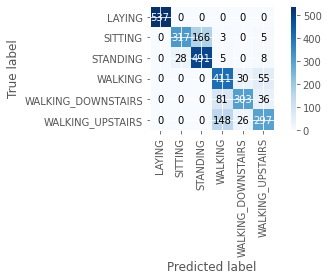

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  MLPClassifier :  0.947495664479252
F1_score: 0.834 	 Time taken: 476.129 secs 	 Classifier: MLPClassifier
Classification Report for  MLPClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      0.95      0.97       537
           SITTING       0.82      0.80      0.81       491
          STANDING       0.83      0.83      0.83       532
           WALKING       0.84      0.88      0.86       496
WALKING_DOWNSTAIRS       0.82      0.72      0.76       420
  WALKING_UPSTAIRS       0.72      0.82      0.77       471

          accuracy                           0.84      2947
         macro avg       0.84      0.83      0.83      2947
      weighted avg       0.84      0.84      0.84      2947

Confusion matrix plot showing for  {'MLPClassifier'} 



<Figure size 288x288 with 0 Axes>

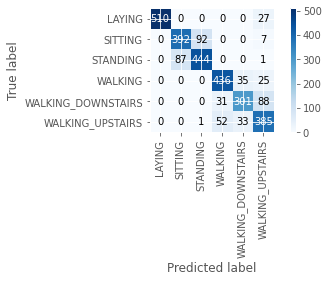

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  LogisticRegression :  0.8974427133191822
F1_score: 0.842 	 Time taken: 48.376 secs 	 Classifier: LogisticRegression
Classification Report for  LogisticRegression :
                     precision    recall  f1-score   support

            LAYING       1.00      0.95      0.97       537
           SITTING       0.84      0.75      0.79       491
          STANDING       0.80      0.86      0.83       532
           WALKING       0.78      0.95      0.86       496
WALKING_DOWNSTAIRS       0.88      0.76      0.81       420
  WALKING_UPSTAIRS       0.81      0.77      0.79       471

          accuracy                           0.85      2947
         macro avg       0.85      0.84      0.84      2947
      weighted avg       0.85      0.85      0.85      2947

Confusion matrix plot showing for  {'LogisticRegression'} 



<Figure size 288x288 with 0 Axes>

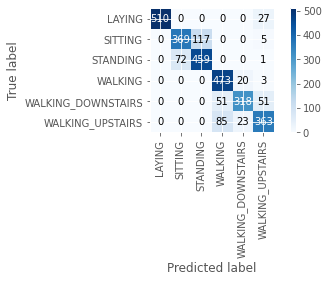

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [ ]:
# evaluating using sfs encoded data
model_score(X_train_sfs, X_test_sfs, y_train_string, y_test_string)

Training accuracy for  KNeighborsClassifier :  0.9657228873874498
F1_score: 0.9 	 Time taken: 8.448 secs 	 Classifier: KNeighborsClassifier
Classification Report for  KNeighborsClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.79      0.84       491
          STANDING       0.83      0.93      0.88       532
           WALKING       0.86      0.97      0.92       496
WALKING_DOWNSTAIRS       0.93      0.80      0.86       420
  WALKING_UPSTAIRS       0.90      0.90      0.90       471

          accuracy                           0.90      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.90      0.90      2947

Confusion matrix plot showing for  {'KNeighborsClassifier'} 



<Figure size 288x288 with 0 Axes>

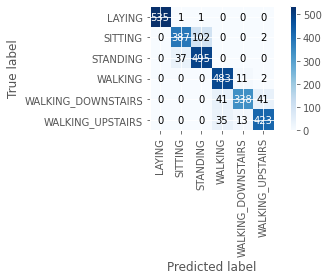

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  SVC :  0.9821816802859825
F1_score: 0.956 	 Time taken: 6.623 secs 	 Classifier: SVC
Classification Report for  SVC :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.95      0.88      0.91       491
          STANDING       0.90      0.96      0.93       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.96      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Confusion matrix plot showing for  {'SVC'} 



<Figure size 288x288 with 0 Axes>

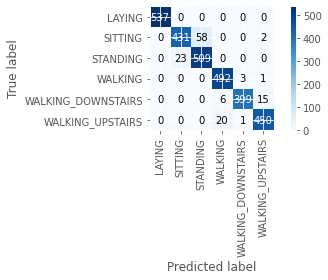

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  DecisionTreeClassifier :  0.8547323538524859
F1_score: 0.813 	 Time taken: 4.674 secs 	 Classifier: DecisionTreeClassifier
Classification Report for  DecisionTreeClassifier :
                     precision    recall  f1-score   support

            LAYING       0.99      0.96      0.97       537
           SITTING       0.77      0.67      0.72       491
          STANDING       0.73      0.85      0.78       532
           WALKING       0.77      0.93      0.84       496
WALKING_DOWNSTAIRS       0.77      0.76      0.77       420
  WALKING_UPSTAIRS       0.90      0.71      0.80       471

          accuracy                           0.82      2947
         macro avg       0.82      0.81      0.81      2947
      weighted avg       0.82      0.82      0.82      2947

Confusion matrix plot showing for  {'DecisionTreeClassifier'} 



<Figure size 288x288 with 0 Axes>

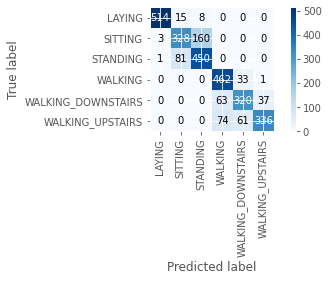

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  RandomForestClassifier :  0.9477690681983194
F1_score: 0.908 	 Time taken: 37.997 secs 	 Classifier: RandomForestClassifier
Classification Report for  RandomForestClassifier :
                     precision    recall  f1-score   support

            LAYING       0.99      1.00      0.99       537
           SITTING       0.88      0.85      0.86       491
          STANDING       0.88      0.90      0.89       532
           WALKING       0.87      0.97      0.91       496
WALKING_DOWNSTAIRS       0.93      0.81      0.87       420
  WALKING_UPSTAIRS       0.93      0.92      0.93       471

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947

Confusion matrix plot showing for  {'RandomForestClassifier'} 



<Figure size 288x288 with 0 Axes>

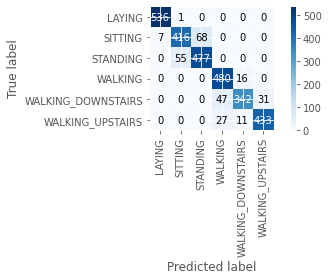

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  GaussianNB :  0.8684722781022673
F1_score: 0.797 	 Time taken: 0.205 secs 	 Classifier: GaussianNB
Classification Report for  GaussianNB :
                     precision    recall  f1-score   support

            LAYING       0.96      0.93      0.95       537
           SITTING       0.88      0.70      0.78       491
          STANDING       0.80      0.86      0.83       532
           WALKING       0.80      0.81      0.81       496
WALKING_DOWNSTAIRS       0.54      0.67      0.60       420
  WALKING_UPSTAIRS       0.85      0.79      0.82       471

          accuracy                           0.80      2947
         macro avg       0.81      0.80      0.80      2947
      weighted avg       0.81      0.80      0.80      2947

Confusion matrix plot showing for  {'GaussianNB'} 



<Figure size 288x288 with 0 Axes>

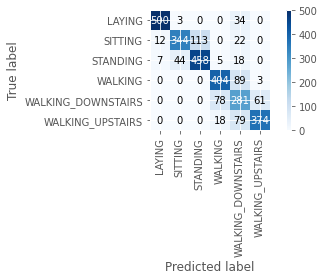

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  MLPClassifier :  0.988575035724691
F1_score: 0.955 	 Time taken: 116.187 secs 	 Classifier: MLPClassifier
Classification Report for  MLPClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      0.95      0.97       537
           SITTING       0.97      0.89      0.93       491
          STANDING       0.87      0.98      0.92       532
           WALKING       0.94      1.00      0.97       496
WALKING_DOWNSTAIRS       1.00      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.94      0.96       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947

Confusion matrix plot showing for  {'MLPClassifier'} 



<Figure size 288x288 with 0 Axes>

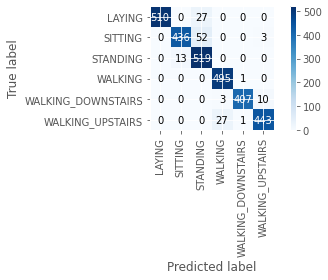

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  LogisticRegression :  0.9832701156601322
F1_score: 0.956 	 Time taken: 66.756 secs 	 Classifier: LogisticRegression
Classification Report for  LogisticRegression :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.87      0.91       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.97       420
  WALKING_UPSTAIRS       0.97      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.95      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Confusion matrix plot showing for  {'LogisticRegression'} 



<Figure size 288x288 with 0 Axes>

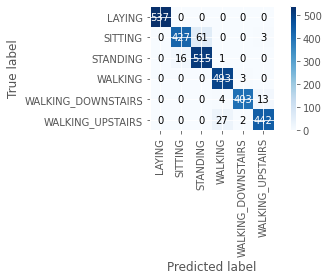

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [ ]:
# evalauating PCA encoded data
model_score(X_train_pca, X_test_pca, y_train_string, y_test_string)

Training accuracy for  KNeighborsClassifier :  0.9469537590699094
F1_score: 0.885 	 Time taken: 4.89 secs 	 Classifier: KNeighborsClassifier
Classification Report for  KNeighborsClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       537
           SITTING       0.88      0.78      0.83       491
          STANDING       0.82      0.91      0.86       532
           WALKING       0.82      0.99      0.90       496
WALKING_DOWNSTAIRS       0.91      0.87      0.89       420
  WALKING_UPSTAIRS       0.92      0.77      0.84       471

          accuracy                           0.89      2947
         macro avg       0.89      0.88      0.88      2947
      weighted avg       0.89      0.89      0.89      2947

Confusion matrix plot showing for  {'KNeighborsClassifier'} 



<Figure size 288x288 with 0 Axes>

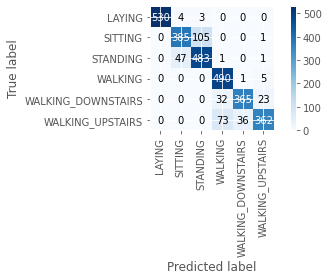

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  SVC :  0.9630036487742617
F1_score: 0.929 	 Time taken: 4.259 secs 	 Classifier: SVC
Classification Report for  SVC :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.94      0.87      0.90       491
          STANDING       0.88      0.94      0.91       532
           WALKING       0.87      0.98      0.92       496
WALKING_DOWNSTAIRS       0.96      0.93      0.95       420
  WALKING_UPSTAIRS       0.95      0.85      0.90       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947

Confusion matrix plot showing for  {'SVC'} 



<Figure size 288x288 with 0 Axes>

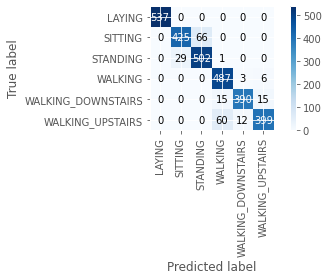

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  DecisionTreeClassifier :  0.92355915037667
F1_score: 0.847 	 Time taken: 1.258 secs 	 Classifier: DecisionTreeClassifier
Classification Report for  DecisionTreeClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.85      0.74      0.79       491
          STANDING       0.79      0.89      0.84       532
           WALKING       0.78      0.92      0.84       496
WALKING_DOWNSTAIRS       0.90      0.76      0.82       420
  WALKING_UPSTAIRS       0.81      0.76      0.79       471

          accuracy                           0.85      2947
         macro avg       0.85      0.85      0.85      2947
      weighted avg       0.86      0.85      0.85      2947

Confusion matrix plot showing for  {'DecisionTreeClassifier'} 



<Figure size 288x288 with 0 Axes>

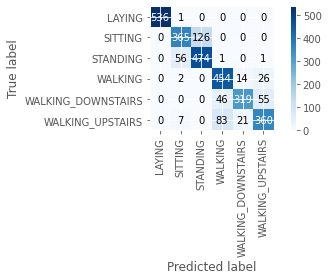

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  RandomForestClassifier :  0.9687163621396893
F1_score: 0.883 	 Time taken: 18.598 secs 	 Classifier: RandomForestClassifier
Classification Report for  RandomForestClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.86      0.82      0.84       491
          STANDING       0.84      0.88      0.86       532
           WALKING       0.83      0.95      0.88       496
WALKING_DOWNSTAIRS       0.97      0.79      0.87       420
  WALKING_UPSTAIRS       0.83      0.85      0.84       471

          accuracy                           0.89      2947
         macro avg       0.89      0.88      0.88      2947
      weighted avg       0.89      0.89      0.89      2947

Confusion matrix plot showing for  {'RandomForestClassifier'} 



<Figure size 288x288 with 0 Axes>

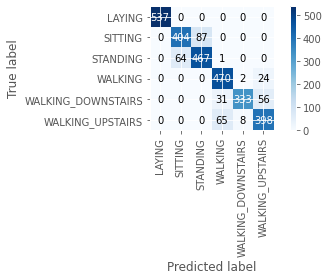

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  GaussianNB :  0.9438253397892128
F1_score: 0.904 	 Time taken: 0.142 secs 	 Classifier: GaussianNB
Classification Report for  GaussianNB :
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.94      0.75      0.83       491
          STANDING       0.81      0.95      0.87       532
           WALKING       0.89      0.97      0.93       496
WALKING_DOWNSTAIRS       0.98      0.87      0.92       420
  WALKING_UPSTAIRS       0.87      0.89      0.88       471

          accuracy                           0.91      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.91      0.91      2947

Confusion matrix plot showing for  {'GaussianNB'} 



<Figure size 288x288 with 0 Axes>

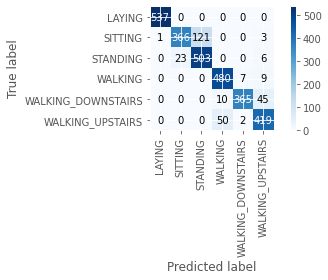

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  MLPClassifier :  0.9757888797939298
F1_score: 0.933 	 Time taken: 284.924 secs 	 Classifier: MLPClassifier
Classification Report for  MLPClassifier :
                     precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.86      0.99      0.92       496
WALKING_DOWNSTAIRS       0.97      0.94      0.95       420
  WALKING_UPSTAIRS       0.95      0.83      0.89       471

          accuracy                           0.93      2947
         macro avg       0.94      0.93      0.93      2947
      weighted avg       0.94      0.93      0.93      2947

Confusion matrix plot showing for  {'MLPClassifier'} 



<Figure size 288x288 with 0 Axes>

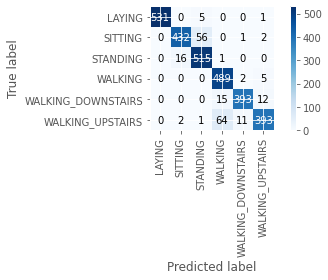

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training accuracy for  LogisticRegression :  0.9616431045565745
F1_score: 0.924 	 Time taken: 27.83 secs 	 Classifier: LogisticRegression
Classification Report for  LogisticRegression :
                     precision    recall  f1-score   support

            LAYING       1.00      0.96      0.98       537
           SITTING       0.95      0.86      0.90       491
          STANDING       0.85      0.95      0.90       532
           WALKING       0.86      0.98      0.92       496
WALKING_DOWNSTAIRS       0.97      0.93      0.95       420
  WALKING_UPSTAIRS       0.94      0.85      0.89       471

          accuracy                           0.92      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.92      0.92      2947

Confusion matrix plot showing for  {'LogisticRegression'} 



<Figure size 288x288 with 0 Axes>

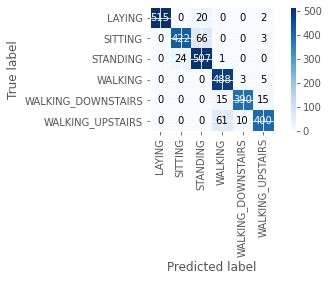

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [ ]:
model_score(X_train_sffs, X_test_sffs, y_train_string, y_test_string)

# Federated Learning Model

In [ ]:
X_train_FL = X_train.to_numpy()
X_test_FL = X_test.to_numpy()

In [ ]:
mms = MinMaxScaler(feature_range=(0, 1))
X_train_FL = mms.fit_transform(X_train_FL)
X_test_FL = mms.transform(X_test_FL)

In [ ]:
# expanding the dimension for 1D convolution
X_test_FL = np.expand_dims(X_test_FL, axis=2)
X_train_FL = np.expand_dims(X_train_FL, axis=2)
X_train_FL.shape

(7352, 561, 1)

In [ ]:
# #binarize the labels
# lb = LabelBinarizer()
# y_train_FL = lb.fit_transform(y_train)
# y_test_FL = lb.transform(y_test)

In [ ]:
def create_clients(data, label, clients_num):

    client_names = ['{}{}'.format('client', i + 1) for i in range(clients_num)]

    #data shuffling
    dataset = list(zip(data, label))
    random.shuffle(dataset)

    #dividing the data according to clients_num
    size = len(dataset)//clients_num
    partitions = [dataset[i:i + size] for i in range(0, size * clients_num, size)]

    if(len(partitions) != clients_num):
        print("Number of clients and data partitions should be the same!")

    partitions_dict = {client_names[i] : partitions[i] for i in range(clients_num)}

    return partitions_dict


In [ ]:
class CNN_model:
    @staticmethod
    def build(n_features, n_timsteps, classes):

        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(n_features, n_timsteps)))
        model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
        model.add(Dropout(0.4))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.4))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Dense(256))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model
    

def scalling_factor(clients_trn_data, client_name):

    client_names = list(clients_trn_data.keys())
    temp = [tf.data.experimental.cardinality(clients_trn_data[cn]).numpy() for cn in client_names]
    global_count = sum(temp)
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()
    scale_factor = local_count/global_count

    return scale_factor


def scale_model_weights(weight, scale_factor):
    w_f = []
    for i in range(len(weight)):
        w_f.append(scale_factor * weight[i])
    return w_f



def sum_scaled_weights(scaled_weights):
    avg = []
    for w in zip(*scaled_weights):
        l_mean = tf.math.reduce_sum(w, axis=0)
        avg.append(l_mean)    
    return avg


def test_model(X_test, Y_test,  model, epoch):
    start = process_time()
    logits = model.predict(X_test)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    end = process_time()
    print('epoch: {} | Accuracy: {:.3%} | Testing time: {:.3} sec'.format(epoch, acc, end - start))
    return acc

In [ ]:
#making the clients 
clients_num = 5
clients = create_clients(X_train_FL, y_train_FL, clients_num)

In [ ]:
#batch size for each epoch
batch_size = 64

#converting each partition to tfds object according to batch_size
client_b = dict()
for (client_name, data) in clients.items():
    data_p, label_p = zip(*data)
    dataset = tf.data.Dataset.from_tensor_slices((list(data_p), list(label_p)))
    client_b[client_name] = dataset.shuffle(len(label_p)).batch(batch_size)

#converting the test data to tfds object
test_batched = tf.data.Dataset.from_tensor_slices((X_test_FL, y_test_FL)).batch(len(y_test_FL))

In [ ]:
#number of global epochs
global_epochs = 50

#optimizer
lr = 0.01 
optimizer = SGD(lr=lr, decay=lr / global_epochs, momentum=0.9) 

#dimension for 1D convlution
n_features = X_train_FL.shape[1]
n_timesteps = X_train_FL.shape[2]

In [ ]:
#initialize global model
CNN = CNN_model()
global_model = CNN.build(n_features, n_timesteps, 6)
FL_Accuracy = []

In [ ]:
for epoch in range(global_epochs):
            
    global_w = global_model.get_weights()
    scaled_local_weight = []

    client_names= list(client_b.keys())
    random.shuffle(client_names)
    
    for client in client_names:
        CNN_local = CNN_model()
        local_model = CNN_local.build(n_features, n_timesteps, 6)
        local_model.compile(loss = 'categorical_crossentropy', 
                      optimizer =optimizer, 
                      metrics = ['accuracy'])
        
        local_model.set_weights(global_w)
        local_model.fit(client_b[client], epochs=2, verbose=0) 

        scaling_factor = scalling_factor(client_b, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight.append(scaled_weights)

        K.clear_session()

    avg_w = sum_scaled_weights(scaled_local_weight)
    global_model.set_weights(avg_w)

    for(Xtest, ytest) in test_batched:
        global_acc = test_model(Xtest, ytest, global_model, epoch)
        FL_Accuracy.append(global_acc)

epoch: 0 | Accuracy: 83.610% | Testing time: 0.333 sec
epoch: 1 | Accuracy: 93.044% | Testing time: 0.219 sec
epoch: 2 | Accuracy: 91.381% | Testing time: 0.216 sec
epoch: 3 | Accuracy: 94.028% | Testing time: 0.215 sec
epoch: 4 | Accuracy: 94.740% | Testing time: 0.218 sec
epoch: 5 | Accuracy: 94.469% | Testing time: 0.213 sec
epoch: 6 | Accuracy: 94.876% | Testing time: 0.209 sec
epoch: 7 | Accuracy: 95.317% | Testing time: 0.211 sec
epoch: 8 | Accuracy: 94.333% | Testing time: 0.211 sec
epoch: 9 | Accuracy: 95.080% | Testing time: 0.211 sec
epoch: 10 | Accuracy: 95.080% | Testing time: 0.21 sec
epoch: 11 | Accuracy: 94.978% | Testing time: 0.222 sec
epoch: 12 | Accuracy: 95.521% | Testing time: 0.213 sec
epoch: 13 | Accuracy: 95.182% | Testing time: 0.21 sec
epoch: 14 | Accuracy: 94.842% | Testing time: 0.218 sec
epoch: 15 | Accuracy: 95.487% | Testing time: 0.216 sec
epoch: 16 | Accuracy: 94.706% | Testing time: 0.217 sec
epoch: 17 | Accuracy: 94.876% | Testing time: 0.209 sec
epoc

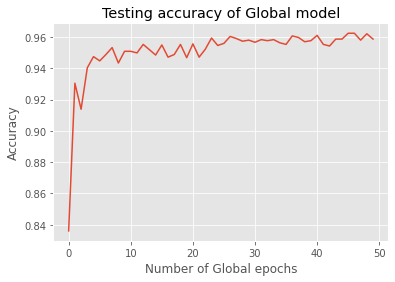

In [ ]:
plt.plot(FL_Accuracy)
plt.xlabel("Number of Global epochs")
plt.ylabel("Accuracy")
plt.title("Testing accuracy of Global model")
plt.show()

In [ ]:
CNN = CNN_model()
model = CNN.build(n_features, n_timesteps, 6) 

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

history = model.fit(X_train_FL, y_train_FL, epochs=50, verbose=0)

for(Xtest, ytest) in test_batched:
        CNN_acc = test_model(Xtest, ytest, model, 1)

epoch: 1 | Accuracy: 95.691% | Testing time: 0.29 sec
